<a href="https://colab.research.google.com/github/viswavich/DLTBACS-PROJECT/blob/main/Nsic_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving CAT.csv to CAT.csv


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


927/927 - 24s - 26ms/step - loss: 0.0034
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


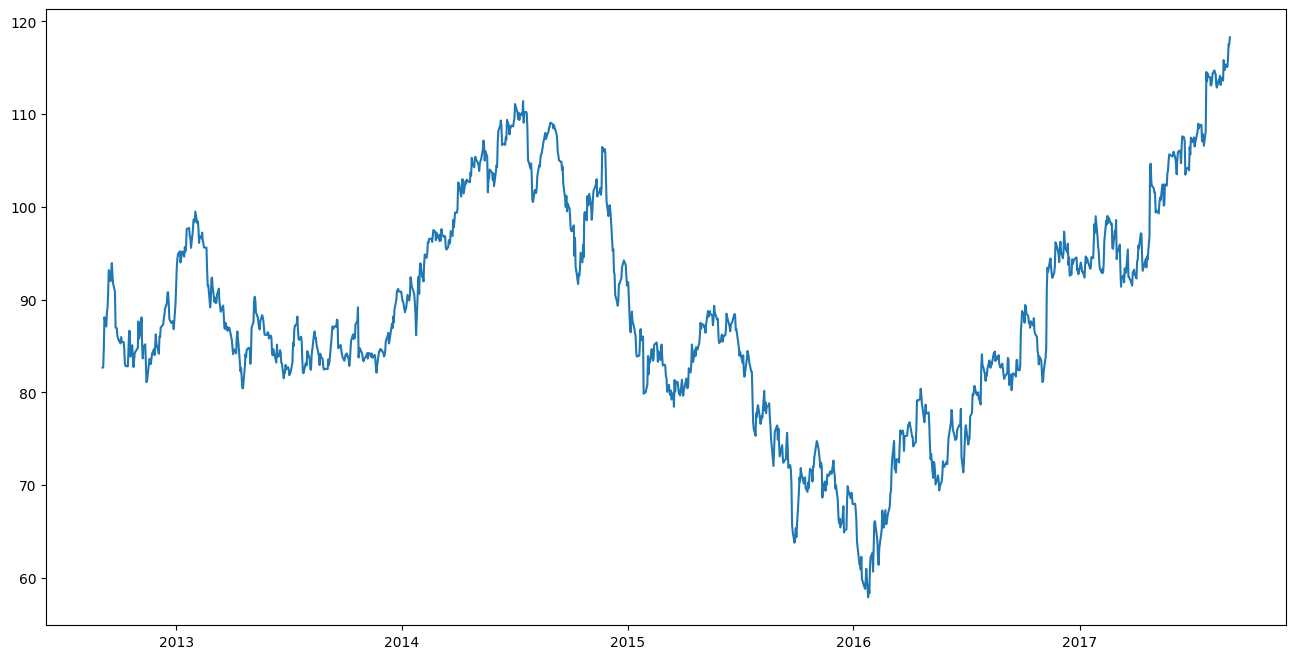

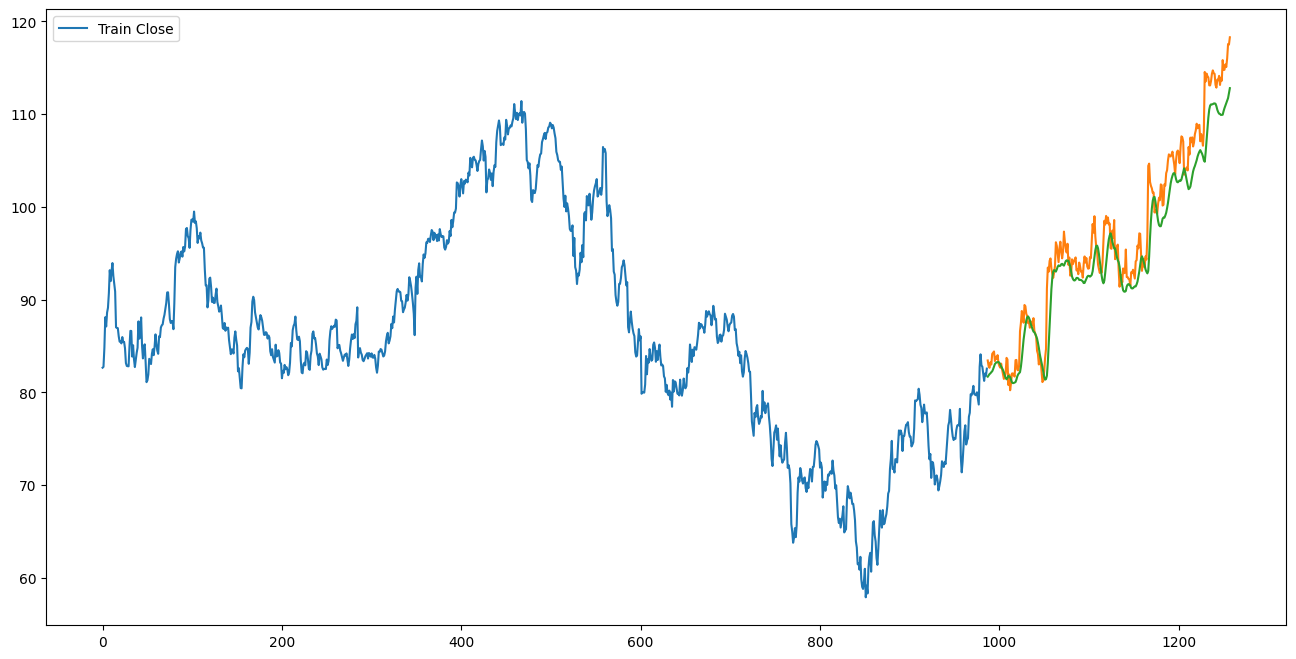

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from matplotlib.pylab import rcParams

# Plot settings
rcParams['figure.figsize'] = 20, 10
%matplotlib inline

# Upload file if using Google Colab
from google.colab import files
uploaded = files.upload()

# Load dataset
df = pd.read_csv("CAT.csv")
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")
df.index = df['Date']

# Plot close price history
plt.figure(figsize=(16, 8))
plt.plot(df["Close"], label='Close Price History')

# Prepare new dataset
data = df.sort_index(ascending=True, axis=0)
new_dataset = pd.DataFrame()
new_dataset["Date"] = data["Date"].values
new_dataset["Close"] = data["Close"].values

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
final_dataset = new_dataset[['Close']].values

# Split into train and validation
train_data = final_dataset[0:987]
valid_data = final_dataset[987:]

# Prepare training data
scaled_data = scaler.fit_transform(final_dataset)
x_train_data, y_train_data = [], []
for i in range(60, len(train_data)):
    x_train_data.append(scaled_data[i-60:i, 0])
    y_train_data.append(scaled_data[i, 0])
x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_data.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(x_train_data, y_train_data, epochs=1, batch_size=1, verbose=2)

# Prepare testing data
inputs_data = final_dataset[len(final_dataset) - len(valid_data) - 60:]
inputs_data = scaler.transform(inputs_data)
X_test = []
for i in range(60, inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions
predicted_closing_price = lstm_model.predict(X_test)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

# Save model
lstm_model.save("saved_model.h5")

# Visualize results
train_data_plot = new_dataset[:987]
valid_data_plot = new_dataset[987:].copy()
valid_data_plot["Predictions"] = predicted_closing_price

plt.figure(figsize=(16, 8))
plt.plot(train_data_plot["Close"], label="Train Close")
plt.plot(valid_data_plot[["Close", "Predictions"]])
plt.legend()
plt.show()